# Explaining classifier decisions using SHAP and MyExplainers

The purpose of this notebook is to compare the plots produced by two different model explanation tools. In order to do so, we are first going to train a classifier using a simple dataset and then use the two different tools to try to explain the classifier's decisions and find previously unknown patterns in the data. 

The first tool is called SHAP (SHapley Additive exPlanations) and it is a game theoretic approach to explain the output of any machine learning model (https://github.com/slundberg/shap). SHAP explains the prediction of a sample by computing the contribution of each feature to the prediction. The computed contributions are called SHAP values. A negative SHAP value indicates a negative contribution to the prediction, while a positive SHAP value means that the feature contributed positively to the model outcome. Furthermore, a high absolute SHAP value indicates a small contributing to the outcome, while a high absolute SHAP value indicates a high contribution. But SHAP does more that just computing the SHAP values, it also offers several different visualisations for them in order to make them readable to the user. In this notebook we are going to focus on three of the offered visualisation: forceplot, stacked forceplot and summary plot.

The second tool, MyExplainers, is a prototype based on the computations of SHAP and therefore uses the same SHAP values, but offers different visualization of these values. We believe, that those visualisations are more informative, interactive and intuitive than the ones offered by SHAP. 

This notebook has the purpose of showing how to use both tools and what the advatages of MyExplainers plots are in comparison to SHAP's plots. 

In [1]:
import pandas as pd
import numpy as np
import copy
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from my_explainers import my_global_explainer, my_local_explainer, get_clusters
import plotly.offline as py
py.init_notebook_mode(connected=True)

## 1. Train and evaluate classifier

In this part we are going to use the titanic dataset to train a Random Forest and evaluate it. The model will predict, wheather a passanger survived the sinking of the Titanic or not. The only data preparation we will perform is to encode the categorical variable "Sex". 

In [2]:
#import dataset
data = pd.read_csv("../datasets/titanic.csv")

In [3]:
#split data into X and y
X, y = data.loc[:, data.columns != 'Survived'], data['Survived']

#save original (not encoded or scaled) data for later
original_data = copy.copy(X)

#encode the categorical variable "Sex"
X = pd.get_dummies(X, ['Sex'])

#split in train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

#train random forest
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)

#evaluate model
y_pred = rforest.predict(X_test)
print("Prcecision Score: {:.2f}".format(precision_score(y_test,y_pred))) 
print("Recall Score: {:.2f}".format(recall_score(y_test,y_pred))) 
print("F1 Score: {:.2f}".format(f1_score(y_test,y_pred))) 

Prcecision Score: 0.73
Recall Score: 0.68
F1 Score: 0.71


## 2. Compute SHAP values

Now we will use SHAP to compute the SHAP values as explained above. These values will then be used for all the plots generated below (for both SHAP and MyExplainers).

In [4]:
#create explainer and compute shap values
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X, check_additivity=False)

## 3. Draw plots for local explanations

The plots drawn in this section are so-called local explanations, which means that we will only look at a single instance and examine what the classifier, in this case the Random Forest trained above, predicts for this input and explain why. Both tools offer a plot dedicated to this use case: SHAP offers "forceplot" and MyExplainers offers "my_local_explainer". In both cases feature attributions (SHAP values) are visualized as "forces". Each feature value is a force that either increases or decreases the prediction. The calculation starts at the base value, which is the average of all predictions. Each SHAP value is an arrow that pushes to increase (positive shap value) or decrease (negative shap value) the prediction. These forces balance each other out at the actual prediction of the data instance (marked as "model output value").


### 3.1 Local explanation with SHAP's forceplot

Below we have drawn a forceplot for the first sample in the dataset, in this case the passenger with ID 0. Below the arrows representing the feature attributions, we can see which features and feature values they belong to. We can for example see, that the fact that the passanger travelled third class had a negative impact on the outcome. We can also see that the output value of the classifier is 0.6 for this passenger.

In [5]:
# load JS visualization code to notebook
shap.initjs()

#select the id of the sample which's prediction we want to explain
prediction = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][prediction,:], X.iloc[prediction])

### 3.2 Local explanation with MyExplainers' my_local_explainer

Before we draw a local explanation with my_local_explainer, we will construct a decoder for the econded variables. This is optional and only useful, if column names have changed during the encoding process. In this case the column "Sex" has been encoded in the columns "Sex_male" and "Sex_female". However, we do not want to see this in the plot, in order to make it easier to understand. 

In this video we explain all the information shown in the plots and highlight the differences between them: https://www.youtube.com/watch?v=y-EK-3a7VsE&feature=youtu.be. Feel free to discover the plots by yourself and find interesting information about the predictions.

In [6]:
#construct decoder for encoded variables
decoder = {"Sex":  ["Sex_male", "Sex_female"] }

my_local_explainer(explainer.expected_value[1], shap_values[1], rforest, original_data, X, 1, decoder)

interactive(children=(BoundedIntText(value=0, description='Sample id:', layout=Layout(padding='10px 640px 0px …

## 4 Draw plots for global explanations

The plots drawn in this section are so-called global explanations, which means that we will not only look at and examine a single instance but look at the predictions for all samples in the dataset in order to try to understand how the above trained classifier works and thereby try to find previously unknown pattterns in the dataset.

The general idea behind both plots that you will see below (staked force plot and my_global_explainer) is the same: first we create forceplots for all samples in the dataset and then we stack them up vertically next to each other ordered by feature value similarity. 


### 4.1.1 Global explanation with SHAP's stacked forceplot

On the x-axis we can see the sample numbers and on the y-axis the output values. By hovering over the plot we also see the feature values for a certain sample.

In [7]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

### 4.1.2 Global explanation with SHAP's summary_plot

The summary plot is also a global explanation. It combines feature importance with feature effects. Each point on the summary plot is a SHAP value for a feature and an sample. The position on the y-axis is determined by the feature and on the x-axis by the corresponding SHAP value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the SHAP values per feature. The features are ordered according to their importance.



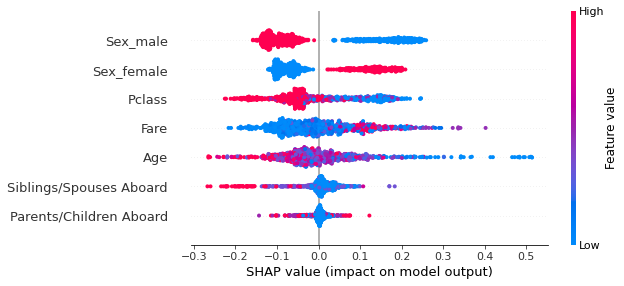

In [8]:
shap.summary_plot(shap_values[1], X)

### 4.2 Global explanation with MyExplainers' my_global_explainer

The plot below is a combination of SHAP's stacked forceplot and summary plot. 

In this video we explain all the information shown in the plot and compare it to SHAP's gloabal explanation plots: https://youtu.be/VybwihOAJVM. Feel free to discover the plots by yourself and find interesting patterns.

In [9]:
my_global_explainer(explainer.expected_value[1], shap_values[1], rforest, original_data, X, 1, decoder)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Threshold for cluster forma…

Below we show how to extract the data in the clusters using "get_cluster". In this case we have specified, that we want the clusters for the threshold 0.25. This method returns a list of dataframes for each cluster. Currently we have visualized the samples in the first cluster.

In [10]:
cluster_data = get_clusters(explainer.expected_value[1], shap_values[1], rforest, original_data, X, 1, 0.25, decoder)
cluster_data[0]

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
442,1,male,4,0,2,81.8583
303,1,male,0.92,1,2,151.55
182,2,male,1,2,1,39
823,2,male,1,0,2,37.0042
77,2,male,0.83,0,2,29
338,2,male,2,1,1,26
192,2,male,3,1,1,26
751,2,male,0.67,1,1,14.5
827,2,male,0.83,1,1,18.75
405,2,male,3,1,1,18.75
